In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!pip install torch torchaudio torchcodec librosa transformers accelerate


In [6]:
import torch
import torchaudio
import librosa
import librosa.display
import matplotlib.pyplot as plt
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [7]:
# 1 # 2
# Path to your file
audio_path = "/content/drive/MyDrive/SpeechProcessing/LJ050-0274.wav"

# Load the signal
waveform, sample_rate = torchaudio.load(audio_path)

# Preprocess: Convert to mono if multi-channel
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Preprocess: Resample to 16kHz
if sample_rate != 16000:
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = resampler(waveform)
    sample_rate = 16000

print(f"Sample Rate: {sample_rate}")
print(f"Waveform Shape: {waveform.shape}")

Sample Rate: 16000
Waveform Shape: torch.Size([1, 72003])


In [8]:
# 3
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import torch

# Load pretrained processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# Prepare input for the model
inputs = processor(
    waveform.squeeze(),
    sampling_rate=sample_rate,
    return_tensors="pt",
    padding=True
)

# Run inference
with torch.no_grad():
    logits = model(inputs.input_values).logits

# Decode predicted tokens
predicted_ids = torch.argmax(logits, dim=-1)
recognized_output = processor.batch_decode(predicted_ids)

print("Recognized Phonemes:")
print(recognized_output[0])


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Recognized Phonemes:
MADE CERTAIN RECOMMENDATIONS WHICH IT BELIEVES WOULD IF ADOPTED


In [10]:
# 4
import numpy as np

# Number of frames output by the model
num_frames = logits.shape[1]

# Total duration of audio in seconds
audio_duration = waveform.shape[1] / sample_rate

# Time duration per frame
time_per_frame = audio_duration / num_frames

print(f"Audio duration (s): {audio_duration:.2f}")
print(f"Number of frames: {num_frames}")
print(f"Time per frame (s): {time_per_frame:.4f}")


Audio duration (s): 4.50
Number of frames: 224
Time per frame (s): 0.0201


In [11]:
# 4
tokens = list(recognized_output[0].replace(" ", ""))

phoneme_intervals = []

for i, token in enumerate(tokens):
    start_time = i * time_per_frame
    end_time = (i + 1) * time_per_frame
    phoneme_intervals.append((token, start_time, end_time))

# Display first few estimated intervals
for p in phoneme_intervals[:10]:
    print(p)

('M', 0.0, 0.020090122767857144)
('A', 0.020090122767857144, 0.04018024553571429)
('D', 0.04018024553571429, 0.06027036830357144)
('E', 0.06027036830357144, 0.08036049107142858)
('C', 0.08036049107142858, 0.10045061383928572)
('E', 0.10045061383928572, 0.12054073660714287)
('R', 0.12054073660714287, 0.140630859375)
('T', 0.140630859375, 0.16072098214285716)
('A', 0.16072098214285716, 0.1808111049107143)
('I', 0.1808111049107143, 0.20090122767857144)


In [23]:
# 5
start_time = 0.02
end_time   = 0.18

sr = sample_rate  # 16000 Hz

start_sample = int(start_time * sr)
end_sample   = int(end_time * sr)

phoneme_segment = waveform[:, start_sample:end_sample]

print("Phoneme segment created with shape:", phoneme_segment.shape)


Phoneme segment created with shape: torch.Size([1, 2560])


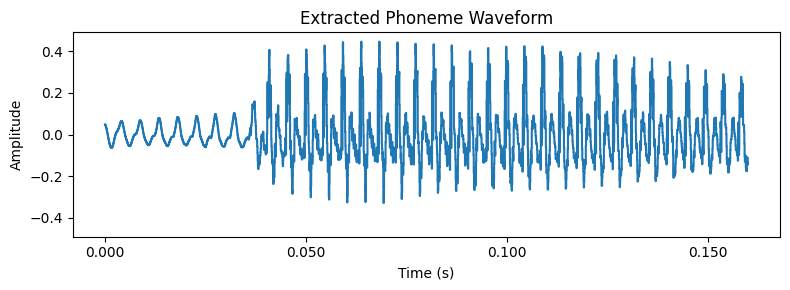

Extracted phoneme saved and visualized successfully.


In [24]:
# 6
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display

# Save extracted phoneme
output_path = "/content/drive/MyDrive/SpeechProcessing/extracted_phoneme.wav"
sf.write(
    output_path,
    phoneme_segment.squeeze().numpy(),
    sample_rate
)

# Visualize extracted phoneme waveform
plt.figure(figsize=(8, 3))
librosa.display.waveshow(
    phoneme_segment.squeeze().numpy(),
    sr=sample_rate
)
plt.title("Extracted Phoneme Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

print("Extracted phoneme saved and visualized successfully.")


Q7
The extracted phoneme waveform has a duration of approximately 150 ms, which is typical for a voiced phoneme. The waveform exhibits clear periodic oscillations with a smooth amplitude envelope, indicating vocal cord vibration during sound production. This confirms that the extracted segment corresponds to a voiced speech sound.